# Packages importation 

In [18]:
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [35]:
from Models.BGE_Adam import BGE_Adam
from Models.models import LogisticRegression, SimpleNN, ComplexNN
from Models.training_validation import training_validation, Trainer
from Models.evaluation import evaluate, evaluate_model, evaluate_model_
from Utils.utils import compare_optimizers, track_gradient_norms
from Utils.Cross_Validate_Hyperparams import cross_validate_hyperparams, cross_validate_accuracy

ModuleNotFoundError: No module named 'Models'

# The MNIST database

In [40]:
# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


In [41]:
def load_mnist_images(file_path):
    """Loads MNIST images from a ubyte file."""
    with open(file_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')  # Magic number
        num_images = int.from_bytes(f.read(4), 'big')    # Number of images 
        num_rows = int.from_bytes(f.read(4), 'big')      # Number of rows per image
        num_cols = int.from_bytes(f.read(4), 'big')      # Number of columns per image
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        return images

In [42]:
def load_mnist_labels(file_path):
    """Loads MNIST labels from a ubyte file."""
    with open(file_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')  # Magic number
        num_labels = int.from_bytes(f.read(4), 'big')   # Labels number
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

In [43]:
train_images_path = os.path.join(path, "train-images.idx3-ubyte")
train_labels_path = os.path.join(path, "train-labels.idx1-ubyte")
test_images_path = os.path.join(path, "t10k-images.idx3-ubyte")
test_labels_path = os.path.join(path, "t10k-labels.idx1-ubyte")

In [44]:
# Loading the data
X_train = load_mnist_images(train_images_path)
y_train = load_mnist_labels(train_labels_path)
X_test = load_mnist_images(test_images_path)
y_test = load_mnist_labels(test_labels_path)

In [45]:
# Data preprocessing
# Flatten and normalize images
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Convert labels to One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Check new shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (60000, 784), y_train shape: (60000, 10)
X_test shape: (10000, 784), y_test shape: (10000, 10)


In [46]:
# Choose of the ratio for the validation set
validation_ratio = 0.2

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=validation_ratio, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(np.argmax(y_valid, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

# Check the shapes
print(f"X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}")
print(f"X_valid shape: {X_valid_tensor.shape}, y_valid shape: {y_valid_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}")


X_train shape: torch.Size([48000, 784]), y_train shape: torch.Size([48000])
X_valid shape: torch.Size([12000, 784]), y_valid shape: torch.Size([12000])
X_test shape: torch.Size([10000, 784]), y_test shape: torch.Size([10000])


Without validation dataset:

\#Convert data into PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)  

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

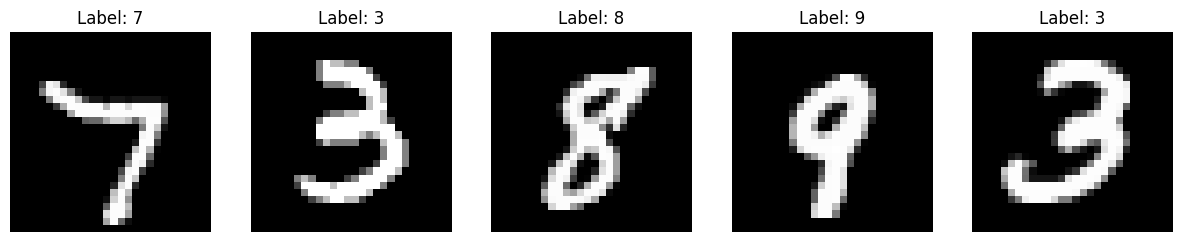

In [47]:
# Visualize some images
def plot_mnist_images(X, y, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = X[i].view(28, 28).detach().numpy()  # Reshape the image to 28x28
        label = y[i].item()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Call the function to plot the images
plot_mnist_images(X_valid_tensor, y_valid_tensor)

In [48]:
print(f"Total number of training examples : {X_train.shape[0]}")
print(f"Total number of validation examples : {X_valid.shape[0]}")
print(f"Total number of test examples : {X_test.shape[0]}")
print(f"Shape of the images : {X_train.shape[1]} (28x28 pixels)")
print(f"Number of classes : {len(torch.unique(y_train_tensor))}")

Total number of training examples : 48000
Total number of validation examples : 12000
Total number of test examples : 10000
Shape of the images : 784 (28x28 pixels)
Number of classes : 10


In [49]:
# Simple statistics on the dataset
print(f"Minimal value of the pixels : {X_train_tensor.min().item()}")
print(f"Maximal value of the pixels : {X_train_tensor.max().item()}")
print(f"Average of the pixels : {X_train_tensor.float().mean().item()}")
print(f"Standard-error of the pixels : {X_train_tensor.float().std().item()}")

Minimal value of the pixels : 0.0
Maximal value of the pixels : 1.0
Average of the pixels : 0.13074526190757751
Standard-error of the pixels : 0.30821332335472107


# Search of the optimal hyperparameters

In [17]:
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))

In [18]:
# Combine training and validation for final training
X_combined = torch.cat([X_train_tensor, X_valid_tensor], dim=0)
y_combined = torch.cat([y_train_tensor, y_valid_tensor], dim=0)

In [19]:
models = {
    'LogisticRegression': LogisticRegression,
    'SimpleNN': SimpleNN,
    'ComplexNN': ComplexNN
}

optimizers = {
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD
}

hyperparams = {
    'Adam': [{'lr': 0.001, 'betas': (0.9, 0.999)}, {'lr': 0.0005, 'betas': (0.85, 0.995)}],
    'SGD': [{'lr': 0.01, 'momentum': 0.9}, {'lr': 0.005, 'momentum': 0.95}]
}

# Table 1 : Hyperparameters (cross-entropy loss)
hyperparams_results = {}
with tqdm(total=len(models) * len(optimizers), desc="Global search of the hyperparamèeters") as pbar:
    for model_name, model_class in models.items():
        for opt_name, opt_class in optimizers.items():
            best_params, _ = cross_validate_hyperparams(
                model_class, opt_class, X_combined, y_combined, hyperparams[opt_name], input_dim, num_classes
            )
            hyperparams_results[f'{model_name}_{opt_name}'] = best_params
            pbar.update(1)

# Table 2 : Average accuracy (rate of correct predictions)
accuracy_results = {}
with tqdm(total=len(models) * len(optimizers), desc="Global validation") as pbar:
    for model_name, model_class in models.items():
        for opt_name, opt_class in optimizers.items():
            accuracy = cross_validate_accuracy(
                model_class, opt_class, X_combined, y_combined, hyperparams_results[f'{model_name}_{opt_name}'], input_dim, num_classes
            )
            accuracy_results[f'{model_name}_{opt_name}'] = accuracy
            pbar.update(1)

# Affichage des résultats
print("Table 1 : Hyperparameters")
print(hyperparams_results)
print("\nTable 2 : Average accuracy")
print(accuracy_results)

Global validation: 100%|██████████| 6/6 [07:13<00:00, 72.22s/it]

Table 1 : Hyperparameters
{'LogisticRegression_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'LogisticRegression_SGD': {'lr': 0.01, 'momentum': 0.9}, 'SimpleNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'SimpleNN_SGD': {'lr': 0.01, 'momentum': 0.9}, 'ComplexNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'ComplexNN_SGD': {'lr': 0.01, 'momentum': 0.9}}

Table 2 : Average accuracy
{'LogisticRegression_Adam': 0.6228833377361298, 'LogisticRegression_SGD': 0.6105333268642426, 'SimpleNN_Adam': 0.665666651725769, 'SimpleNN_SGD': 0.26158333420753477, 'ComplexNN_Adam': 0.39226666986942293, 'ComplexNN_SGD': 0.10636666715145111}


In [50]:
hyperparams_results = {'LogisticRegression_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'LogisticRegression_SGD': {'lr': 0.01, 'momentum': 0.9}, 'SimpleNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'SimpleNN_SGD': {'lr': 0.01, 'momentum': 0.9}, 'ComplexNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'ComplexNN_SGD': {'lr': 0.01, 'momentum': 0.9}}
accuracy_results = {'LogisticRegression_Adam': 0.6228833377361298, 'LogisticRegression_SGD': 0.6105333268642426, 'SimpleNN_Adam': 0.665666651725769, 'SimpleNN_SGD': 0.26158333420753477, 'ComplexNN_Adam': 0.39226666986942293, 'ComplexNN_SGD': 0.10636666715145111}

# Logistic regression

## BGE-Adam optimizer

In [35]:
# Model parameters
input_dim = X_train.shape[1]  # 784
num_classes = y_train.shape[1]  # 10

# Initializing the model, optimizer and loss function
model = LogisticRegression(input_dim, num_classes)
optimizer = BGE_Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")


Epoch 1/20, Train Loss: 0.3724, Val Loss: 0.3179, Val Accuracy: 0.9128
Epoch 2/20, Train Loss: 0.3221, Val Loss: 0.3323, Val Accuracy: 0.9160
Epoch 3/20, Train Loss: 0.3157, Val Loss: 0.3611, Val Accuracy: 0.9058
Epoch 4/20, Train Loss: 0.3184, Val Loss: 0.3419, Val Accuracy: 0.9116
Epoch 5/20, Train Loss: 0.3158, Val Loss: 0.3429, Val Accuracy: 0.9166
Epoch 6/20, Train Loss: 0.3164, Val Loss: 0.3491, Val Accuracy: 0.9172
Epoch 7/20, Train Loss: 0.3168, Val Loss: 0.3589, Val Accuracy: 0.9163
Epoch 8/20, Train Loss: 0.3156, Val Loss: 0.3643, Val Accuracy: 0.9169
Epoch 9/20, Train Loss: 0.3153, Val Loss: 0.3696, Val Accuracy: 0.9158
Epoch 10/20, Train Loss: 0.3187, Val Loss: 0.3929, Val Accuracy: 0.9097
Epoch 11/20, Train Loss: 0.3169, Val Loss: 0.3731, Val Accuracy: 0.9132
Epoch 12/20, Train Loss: 0.3167, Val Loss: 0.3991, Val Accuracy: 0.9083
Epoch 13/20, Train Loss: 0.3183, Val Loss: 0.3801, Val Accuracy: 0.9168
Epoch 14/20, Train Loss: 0.3195, Val Loss: 0.3732, Val Accuracy: 0.9151
E

In [175]:
# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Test Accuracy: 0.9163


In [176]:
evaluate(model, X_test_tensor, y_test_tensor)

Test Accuracy: 0.9163


## Adam optimizer

In [179]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/20, Train Loss: 0.3217, Val Loss: 0.4223, Val Accuracy: 0.9047
Epoch 2/20, Train Loss: 0.3056, Val Loss: 0.3934, Val Accuracy: 0.9095
Epoch 3/20, Train Loss: 0.2963, Val Loss: 0.3819, Val Accuracy: 0.9080
Epoch 4/20, Train Loss: 0.2892, Val Loss: 0.3767, Val Accuracy: 0.9086
Epoch 5/20, Train Loss: 0.2860, Val Loss: 0.3764, Val Accuracy: 0.9119
Epoch 6/20, Train Loss: 0.2866, Val Loss: 0.3998, Val Accuracy: 0.9013
Epoch 7/20, Train Loss: 0.2817, Val Loss: 0.3729, Val Accuracy: 0.9112
Epoch 8/20, Train Loss: 0.2792, Val Loss: 0.3564, Val Accuracy: 0.9158
Epoch 9/20, Train Loss: 0.2811, Val Loss: 0.3688, Val Accuracy: 0.9113
Epoch 10/20, Train Loss: 0.2769, Val Loss: 0.3607, Val Accuracy: 0.9135
Epoch 11/20, Train Loss: 0.2722, Val Loss: 0.3775, Val Accuracy: 0.9065
Epoch 12/20, Train Loss: 0.2734, Val Loss: 0.3756, Val Accuracy: 0.9076
Epoch 13/20, Train Loss: 0.2714, Val Loss: 0.3737, Val Accuracy: 0.9110
Epoch 14/20, Train Loss: 0.2676, Val Loss: 0.3692, Val Accuracy: 0.9112
E

## SGD optimizer

In [180]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/20, Train Loss: 0.2253, Val Loss: 0.3469, Val Accuracy: 0.9162
Epoch 2/20, Train Loss: 0.2202, Val Loss: 0.3445, Val Accuracy: 0.9164
Epoch 3/20, Train Loss: 0.2182, Val Loss: 0.3428, Val Accuracy: 0.9172
Epoch 4/20, Train Loss: 0.2167, Val Loss: 0.3415, Val Accuracy: 0.9179
Epoch 5/20, Train Loss: 0.2154, Val Loss: 0.3407, Val Accuracy: 0.9178
Epoch 6/20, Train Loss: 0.2144, Val Loss: 0.3400, Val Accuracy: 0.9182
Epoch 7/20, Train Loss: 0.2136, Val Loss: 0.3392, Val Accuracy: 0.9186
Epoch 8/20, Train Loss: 0.2129, Val Loss: 0.3388, Val Accuracy: 0.9184
Epoch 9/20, Train Loss: 0.2123, Val Loss: 0.3385, Val Accuracy: 0.9193
Epoch 10/20, Train Loss: 0.2118, Val Loss: 0.3382, Val Accuracy: 0.9197
Epoch 11/20, Train Loss: 0.2113, Val Loss: 0.3378, Val Accuracy: 0.9196
Epoch 12/20, Train Loss: 0.2110, Val Loss: 0.3374, Val Accuracy: 0.9196
Epoch 13/20, Train Loss: 0.2106, Val Loss: 0.3372, Val Accuracy: 0.9200
Epoch 14/20, Train Loss: 0.2103, Val Loss: 0.3373, Val Accuracy: 0.9193
E

## Comparison of optimizers

In [57]:
class Trainer:
    def __init__(self, model_class, input_dim, num_classes, criterion, optimizers, epochs=120, batch_size=64):
        """
        Initialise la classe Trainer.

        Parameters:
        - model_class: La classe du modèle (ex. LogisticRegression, SimpleNN, etc.).
        - input_dim: Dimension des entrées.
        - num_classes: Nombre de classes de sortie.
        - criterion: La fonction de perte.
        - optimizers: Dictionnaire des optimiseurs à comparer (nom -> classe).
        - epochs: Nombre d'époques d'entraînement.
        - batch_size: Taille des mini-lots.
        """
        self.model_class = model_class
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.criterion = criterion
        self.optimizers = optimizers
        self.epochs = epochs
        self.batch_size = batch_size

    def train_and_validate(self, model, optimizer, X_train, y_train, X_valid, y_valid):
        """
        Entraîne et valide un modèle.

        Returns:
        - train_losses, val_losses, val_accuracies: Listes des métriques d'entraînement et de validation.
        """
        num_samples = X_train.shape[0]
        train_losses = []
        val_losses = []
        val_accuracies = []

        for epoch in range(self.epochs):
            model.train() # Mode entraînement
            epoch_loss = 0

            # Mélange aléatoire des données
            perm = torch.randperm(num_samples)
            X_train = X_train[perm]
            y_train = y_train[perm]

            # Entraînement par mini-lots
            for i in range(0, num_samples, self.batch_size):
                X_batch = X_train[i:i+self.batch_size]
                y_batch = y_train[i:i+self.batch_size]

                # Réinitialisation des gradients
                optimizer.zero_grad()

                # Forward and backward
                outputs = model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # Calcul de la perte moyenne pour l'époque
            train_loss = epoch_loss / (num_samples // self.batch_size)
            train_losses.append(train_loss)

            # Validation
            model.eval()    # Mode évaluation
            with torch.no_grad():
                val_outputs = model(X_valid)
                val_loss = self.criterion(val_outputs, y_valid).item()
                val_losses.append(val_loss)

                # Calcul de la précision
                val_predictions = torch.argmax(val_outputs, dim=1)
                val_accuracy = (val_predictions == y_valid).float().mean().item()
                val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        return train_losses, val_losses, val_accuracies

    def compare_optimizers(self, X_train, y_train, X_valid, y_valid, hyperparams_results):
        """
        Compare les optimiseurs en termes de convergence, stabilité et précision.

        Returns:
        - results: Dictionnaire contenant les métriques de chaque optimiseur.
        """
        results = {}

        for name, opt_class in self.optimizers.items():
            print(f"\nRunning {name} optimizer...")
            model = self.model_class(self.input_dim, self.num_classes)

            if name == "BGE_Adam":
                params = {'lr':0.01}
            else:
                params = hyperparams_results[f'{self.model_class.__name__}_{name}']

            optimizer = opt_class(model.parameters(), **params)

            train_losses, val_losses, val_accuracies = self.train_and_validate(
                model, optimizer, X_train, y_train, X_valid, y_valid
            )

            results[name] = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }

        self.plot_results(results)
        return results

    def plot_results(self, results):
        """
        Trace les courbes des pertes et précisions pour chaque optimiseur.
        """
        plt.figure(figsize=(14, 6))

        # Train Losses
        plt.subplot(1, 2, 1)
        for name, metrics in results.items():
            plt.plot(metrics['train_losses'], label=name)
        plt.title("Train Losses")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # Validation Accuracy
        plt.subplot(1, 2, 2)
        for name, metrics in results.items():
            plt.plot(metrics['val_accuracies'], label=name)
        plt.title("Validation Accuracies")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [63]:
# Definition of the logistic regression class
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)


Running SGD optimizer...
Epoch 1/20, Train Loss: 0.5118, Val Loss: 0.3686, Val Accuracy: 0.8982
Epoch 2/20, Train Loss: 0.3483, Val Loss: 0.3304, Val Accuracy: 0.9091
Epoch 3/20, Train Loss: 0.3233, Val Loss: 0.3132, Val Accuracy: 0.9118
Epoch 4/20, Train Loss: 0.3093, Val Loss: 0.3051, Val Accuracy: 0.9158
Epoch 5/20, Train Loss: 0.3008, Val Loss: 0.3014, Val Accuracy: 0.9170
Epoch 6/20, Train Loss: 0.2943, Val Loss: 0.2970, Val Accuracy: 0.9177
Epoch 7/20, Train Loss: 0.2895, Val Loss: 0.2984, Val Accuracy: 0.9153
Epoch 8/20, Train Loss: 0.2855, Val Loss: 0.2890, Val Accuracy: 0.9193
Epoch 9/20, Train Loss: 0.2818, Val Loss: 0.2895, Val Accuracy: 0.9197
Epoch 10/20, Train Loss: 0.2792, Val Loss: 0.2873, Val Accuracy: 0.9212
Epoch 11/20, Train Loss: 0.2768, Val Loss: 0.2849, Val Accuracy: 0.9212
Epoch 12/20, Train Loss: 0.2748, Val Loss: 0.2865, Val Accuracy: 0.9219
Epoch 13/20, Train Loss: 0.2727, Val Loss: 0.2833, Val Accuracy: 0.9207
Epoch 14/20, Train Loss: 0.2711, Val Loss: 0.28

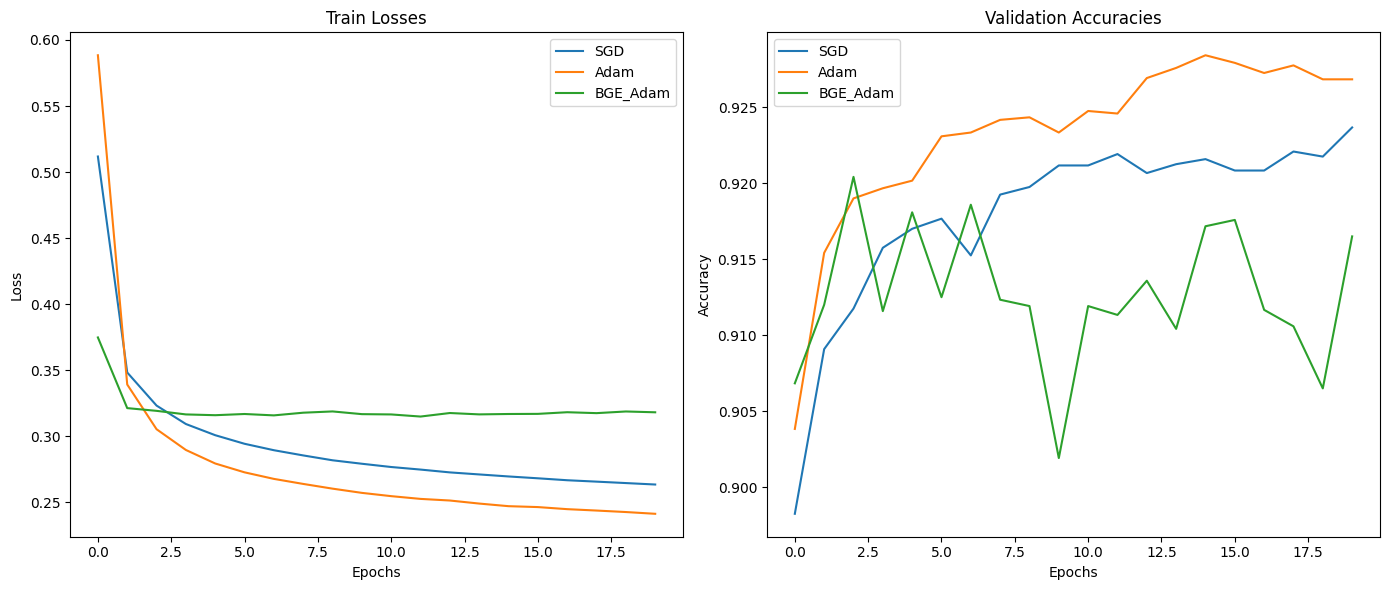

In [ ]:
# Données
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))

# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=LogisticRegression,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=120,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    hyperparams_results=hyperparams_results
)

# Simple neural network

## BGE-Adam optimizer

In [181]:
# Model parameters
input_dim = X_train.shape[1]  # 784
num_classes = y_train.shape[1]  # 10

# Initializing the model, optimizer and loss function
model = SimpleNN(input_dim, num_classes)
optimizer = BGE_Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

In [182]:
# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/20, Train Loss: 0.2626, Val Loss: 0.1622, Val Accuracy: 0.9533
Epoch 2/20, Train Loss: 0.1522, Val Loss: 0.1441, Val Accuracy: 0.9631
Epoch 3/20, Train Loss: 0.1303, Val Loss: 0.1789, Val Accuracy: 0.9611
Epoch 4/20, Train Loss: 0.1234, Val Loss: 0.2056, Val Accuracy: 0.9622
Epoch 5/20, Train Loss: 0.1133, Val Loss: 0.1950, Val Accuracy: 0.9650
Epoch 6/20, Train Loss: 0.0999, Val Loss: 0.2341, Val Accuracy: 0.9631
Epoch 7/20, Train Loss: 0.1016, Val Loss: 0.2556, Val Accuracy: 0.9657
Epoch 8/20, Train Loss: 0.0908, Val Loss: 0.2644, Val Accuracy: 0.9654
Epoch 9/20, Train Loss: 0.0884, Val Loss: 0.2462, Val Accuracy: 0.9645
Epoch 10/20, Train Loss: 0.0880, Val Loss: 0.3142, Val Accuracy: 0.9638
Epoch 11/20, Train Loss: 0.0804, Val Loss: 0.3475, Val Accuracy: 0.9651
Epoch 12/20, Train Loss: 0.0760, Val Loss: 0.3100, Val Accuracy: 0.9679
Epoch 13/20, Train Loss: 0.0720, Val Loss: 0.3348, Val Accuracy: 0.9669
Epoch 14/20, Train Loss: 0.0710, Val Loss: 0.3381, Val Accuracy: 0.9654
E

## Adam optimizer

In [183]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/20, Train Loss: 0.1125, Val Loss: 0.4802, Val Accuracy: 0.9594
Epoch 2/20, Train Loss: 0.1015, Val Loss: 0.4549, Val Accuracy: 0.9607
Epoch 3/20, Train Loss: 0.0943, Val Loss: 0.4435, Val Accuracy: 0.9603
Epoch 4/20, Train Loss: 0.0917, Val Loss: 0.4327, Val Accuracy: 0.9628
Epoch 5/20, Train Loss: 0.0836, Val Loss: 0.4914, Val Accuracy: 0.9605
Epoch 6/20, Train Loss: 0.0758, Val Loss: 0.4392, Val Accuracy: 0.9656
Epoch 7/20, Train Loss: 0.0744, Val Loss: 0.4779, Val Accuracy: 0.9653
Epoch 8/20, Train Loss: 0.0701, Val Loss: 0.4651, Val Accuracy: 0.9632
Epoch 9/20, Train Loss: 0.0723, Val Loss: 0.4906, Val Accuracy: 0.9614
Epoch 10/20, Train Loss: 0.0701, Val Loss: 0.4938, Val Accuracy: 0.9641
Epoch 11/20, Train Loss: 0.0695, Val Loss: 0.4435, Val Accuracy: 0.9670
Epoch 12/20, Train Loss: 0.0529, Val Loss: 0.4722, Val Accuracy: 0.9638
Epoch 13/20, Train Loss: 0.0716, Val Loss: 0.5219, Val Accuracy: 0.9663
Epoch 14/20, Train Loss: 0.0636, Val Loss: 0.4924, Val Accuracy: 0.9653
E

## SGD optimizer

In [184]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/20, Train Loss: 0.0318, Val Loss: 0.5344, Val Accuracy: 0.9686
Epoch 2/20, Train Loss: 0.0226, Val Loss: 0.5216, Val Accuracy: 0.9692
Epoch 3/20, Train Loss: 0.0187, Val Loss: 0.5144, Val Accuracy: 0.9697
Epoch 4/20, Train Loss: 0.0162, Val Loss: 0.5098, Val Accuracy: 0.9699
Epoch 5/20, Train Loss: 0.0143, Val Loss: 0.5074, Val Accuracy: 0.9699
Epoch 6/20, Train Loss: 0.0130, Val Loss: 0.5045, Val Accuracy: 0.9700
Epoch 7/20, Train Loss: 0.0119, Val Loss: 0.5021, Val Accuracy: 0.9702
Epoch 8/20, Train Loss: 0.0110, Val Loss: 0.5005, Val Accuracy: 0.9701
Epoch 9/20, Train Loss: 0.0101, Val Loss: 0.4991, Val Accuracy: 0.9702
Epoch 10/20, Train Loss: 0.0094, Val Loss: 0.4983, Val Accuracy: 0.9704
Epoch 11/20, Train Loss: 0.0088, Val Loss: 0.4970, Val Accuracy: 0.9706
Epoch 12/20, Train Loss: 0.0082, Val Loss: 0.4963, Val Accuracy: 0.9706
Epoch 13/20, Train Loss: 0.0077, Val Loss: 0.4955, Val Accuracy: 0.9706
Epoch 14/20, Train Loss: 0.0073, Val Loss: 0.4945, Val Accuracy: 0.9708
E

## Comparison of optimizers


Running SGD optimizer...
Epoch 1/20, Train Loss: 0.5307, Val Loss: 0.3036, Val Accuracy: 0.9133
Epoch 2/20, Train Loss: 0.2704, Val Loss: 0.2503, Val Accuracy: 0.9283
Epoch 3/20, Train Loss: 0.2155, Val Loss: 0.2006, Val Accuracy: 0.9425
Epoch 4/20, Train Loss: 0.1764, Val Loss: 0.1671, Val Accuracy: 0.9524
Epoch 5/20, Train Loss: 0.1503, Val Loss: 0.1517, Val Accuracy: 0.9564
Epoch 6/20, Train Loss: 0.1314, Val Loss: 0.1419, Val Accuracy: 0.9589
Epoch 7/20, Train Loss: 0.1158, Val Loss: 0.1278, Val Accuracy: 0.9629
Epoch 8/20, Train Loss: 0.1041, Val Loss: 0.1179, Val Accuracy: 0.9660
Epoch 9/20, Train Loss: 0.0946, Val Loss: 0.1114, Val Accuracy: 0.9687
Epoch 10/20, Train Loss: 0.0862, Val Loss: 0.1133, Val Accuracy: 0.9672
Epoch 11/20, Train Loss: 0.0795, Val Loss: 0.1028, Val Accuracy: 0.9712
Epoch 12/20, Train Loss: 0.0725, Val Loss: 0.0994, Val Accuracy: 0.9710
Epoch 13/20, Train Loss: 0.0674, Val Loss: 0.1010, Val Accuracy: 0.9713
Epoch 14/20, Train Loss: 0.0631, Val Loss: 0.09

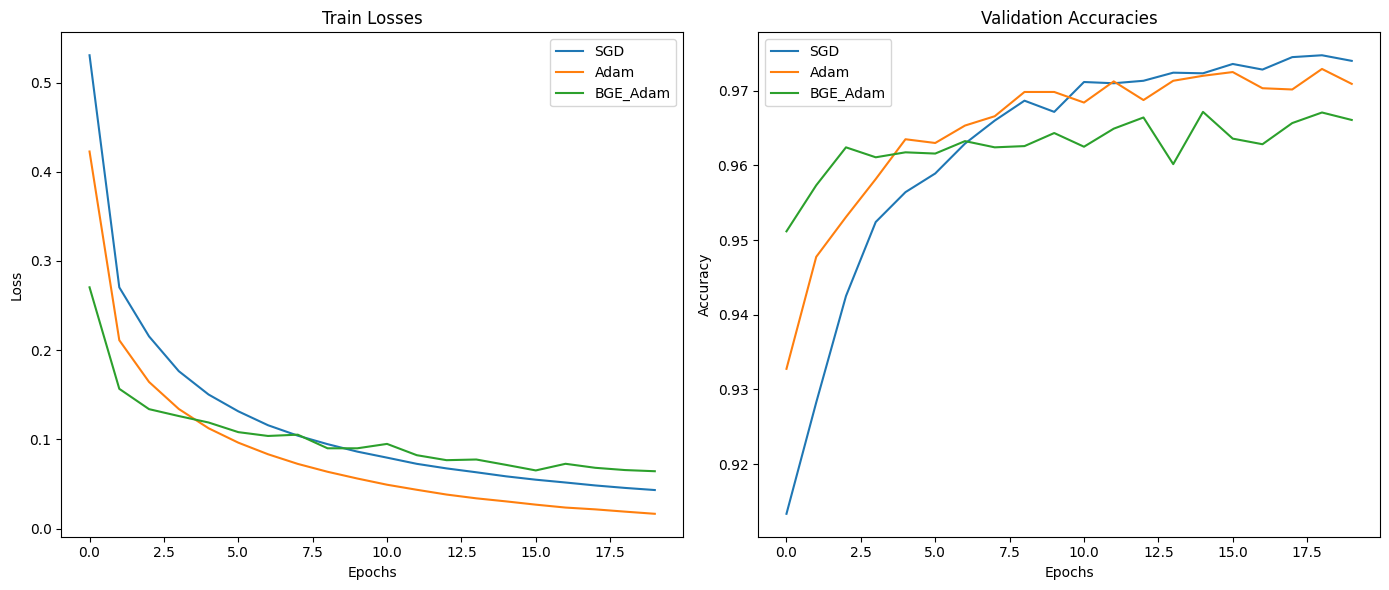

In [65]:
# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=SimpleNN,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=120,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    hyperparams_results=hyperparams_results
)

# Complex neural network

## BGE-Adam optimizer

In [67]:
# Model parameters
input_dim = X_train.shape[1]  # 784
num_classes = y_train.shape[1]  # 10

# Initializing the model, optimizer and loss function
model = ComplexNN(input_dim, num_classes)
optimizer = BGE_Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

In [186]:
# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/20, Train Loss: 0.6669, Val Loss: 0.2646, Val Accuracy: 0.9337
Epoch 2/20, Train Loss: 0.5008, Val Loss: 0.2664, Val Accuracy: 0.9367
Epoch 3/20, Train Loss: 0.4846, Val Loss: 0.2588, Val Accuracy: 0.9344
Epoch 4/20, Train Loss: 0.4838, Val Loss: 0.2585, Val Accuracy: 0.9379
Epoch 5/20, Train Loss: 0.4731, Val Loss: 0.2631, Val Accuracy: 0.9370
Epoch 6/20, Train Loss: 0.4670, Val Loss: 0.2422, Val Accuracy: 0.9431
Epoch 7/20, Train Loss: 0.4763, Val Loss: 0.2536, Val Accuracy: 0.9442
Epoch 8/20, Train Loss: 0.4785, Val Loss: 0.2444, Val Accuracy: 0.9400
Epoch 9/20, Train Loss: 0.4775, Val Loss: 0.2319, Val Accuracy: 0.9430
Epoch 10/20, Train Loss: 0.4690, Val Loss: 0.2561, Val Accuracy: 0.9427
Epoch 11/20, Train Loss: 0.4771, Val Loss: 0.2473, Val Accuracy: 0.9456
Epoch 12/20, Train Loss: 0.4814, Val Loss: 0.2658, Val Accuracy: 0.9444
Epoch 13/20, Train Loss: 0.4928, Val Loss: 0.2565, Val Accuracy: 0.9473
Epoch 14/20, Train Loss: 0.5036, Val Loss: 0.2608, Val Accuracy: 0.9448
E

## Adam optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/20, Train Loss: 0.6548, Val Loss: 0.2892, Val Accuracy: 0.9192
Epoch 2/20, Train Loss: 0.4714, Val Loss: 0.2432, Val Accuracy: 0.9362
Epoch 3/20, Train Loss: 0.4514, Val Loss: 0.2468, Val Accuracy: 0.9349
Epoch 4/20, Train Loss: 0.4227, Val Loss: 0.2353, Val Accuracy: 0.9419
Epoch 5/20, Train Loss: 0.4038, Val Loss: 0.2250, Val Accuracy: 0.9439
Epoch 6/20, Train Loss: 0.3920, Val Loss: 0.2241, Val Accuracy: 0.9414
Epoch 7/20, Train Loss: 0.3936, Val Loss: 0.1981, Val Accuracy: 0.9480
Epoch 8/20, Train Loss: 0.3822, Val Loss: 0.2227, Val Accuracy: 0.9420
Epoch 9/20, Train Loss: 0.3785, Val Loss: 0.2061, Val Accuracy: 0.9491
Epoch 10/20, Train Loss: 0.3769, Val Loss: 0.2160, Val Accuracy: 0.9440
Epoch 11/20, Train Loss: 0.3622, Val Loss: 0.2200, Val Accuracy: 0.9462
Epoch 12/20, Train Loss: 0.3631, Val Loss: 0.2186, Val Accuracy: 0.9453
Epoch 13/20, Train Loss: 0.3566, Val Loss: 0.2021, Val Accuracy: 0.9473
Epoch 14/20, Train Loss: 0.3665, Val Loss: 0.2031, Val Accuracy: 0.9484
E

## SGD optimizer

In [69]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/20, Train Loss: 0.3121, Val Loss: 0.1913, Val Accuracy: 0.9505
Epoch 2/20, Train Loss: 0.3099, Val Loss: 0.1893, Val Accuracy: 0.9517
Epoch 3/20, Train Loss: 0.3048, Val Loss: 0.1911, Val Accuracy: 0.9511
Epoch 4/20, Train Loss: 0.2985, Val Loss: 0.1924, Val Accuracy: 0.9523
Epoch 5/20, Train Loss: 0.3000, Val Loss: 0.1886, Val Accuracy: 0.9520
Epoch 6/20, Train Loss: 0.2943, Val Loss: 0.1879, Val Accuracy: 0.9517
Epoch 7/20, Train Loss: 0.2981, Val Loss: 0.1870, Val Accuracy: 0.9517
Epoch 8/20, Train Loss: 0.2972, Val Loss: 0.1876, Val Accuracy: 0.9522
Epoch 9/20, Train Loss: 0.2912, Val Loss: 0.1869, Val Accuracy: 0.9524
Epoch 10/20, Train Loss: 0.2951, Val Loss: 0.1864, Val Accuracy: 0.9515
Epoch 11/20, Train Loss: 0.2853, Val Loss: 0.1871, Val Accuracy: 0.9514
Epoch 12/20, Train Loss: 0.2860, Val Loss: 0.1859, Val Accuracy: 0.9525
Epoch 13/20, Train Loss: 0.2925, Val Loss: 0.1859, Val Accuracy: 0.9526
Epoch 14/20, Train Loss: 0.2837, Val Loss: 0.1840, Val Accuracy: 0.9526
E

## Comparison optimizers


Running SGD optimizer...
Epoch 1/20, Train Loss: 1.1757, Val Loss: 0.3453, Val Accuracy: 0.8997
Epoch 2/20, Train Loss: 0.4493, Val Loss: 0.2170, Val Accuracy: 0.9377
Epoch 3/20, Train Loss: 0.3524, Val Loss: 0.1779, Val Accuracy: 0.9500
Epoch 4/20, Train Loss: 0.3008, Val Loss: 0.1607, Val Accuracy: 0.9544
Epoch 5/20, Train Loss: 0.2740, Val Loss: 0.1454, Val Accuracy: 0.9561
Epoch 6/20, Train Loss: 0.2556, Val Loss: 0.1373, Val Accuracy: 0.9593
Epoch 7/20, Train Loss: 0.2415, Val Loss: 0.1265, Val Accuracy: 0.9628
Epoch 8/20, Train Loss: 0.2249, Val Loss: 0.1303, Val Accuracy: 0.9618
Epoch 9/20, Train Loss: 0.2154, Val Loss: 0.1227, Val Accuracy: 0.9641
Epoch 10/20, Train Loss: 0.2082, Val Loss: 0.1205, Val Accuracy: 0.9647
Epoch 11/20, Train Loss: 0.2036, Val Loss: 0.1216, Val Accuracy: 0.9632
Epoch 12/20, Train Loss: 0.1961, Val Loss: 0.1146, Val Accuracy: 0.9666
Epoch 13/20, Train Loss: 0.1926, Val Loss: 0.1117, Val Accuracy: 0.9669
Epoch 14/20, Train Loss: 0.1892, Val Loss: 0.10

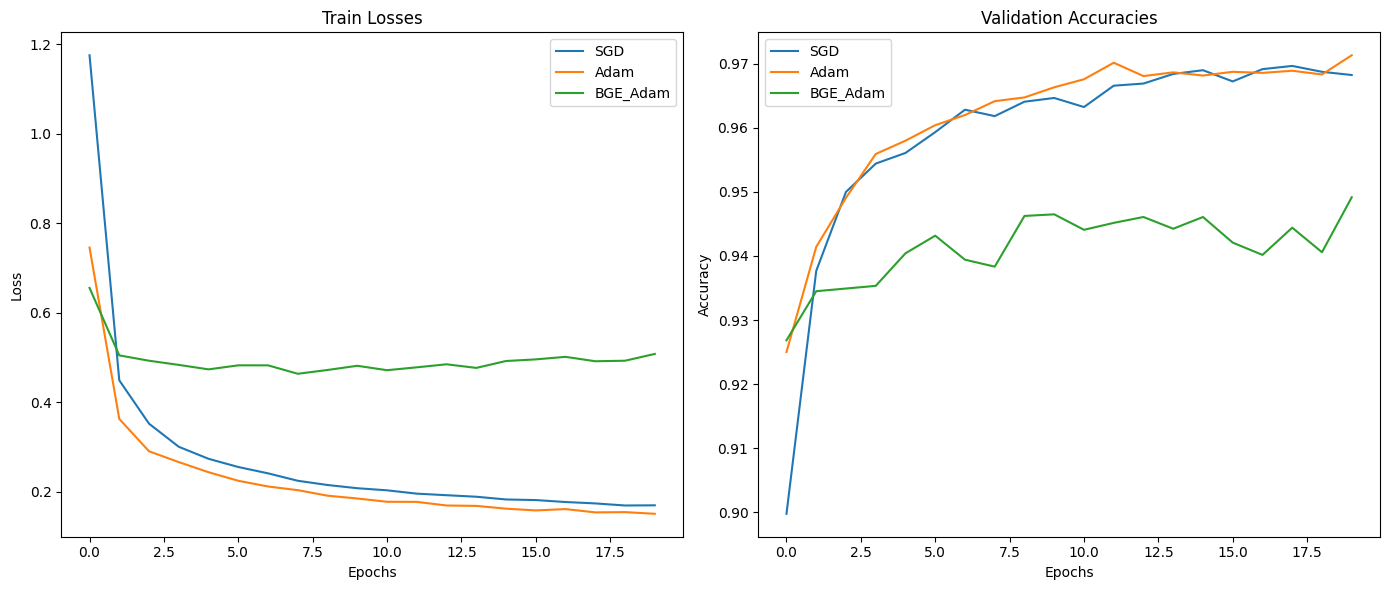

In [70]:
# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=ComplexNN,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=120,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    hyperparams_results=hyperparams_results
)

# Comparison of the gradient norms across training for all three models and all three optimizers

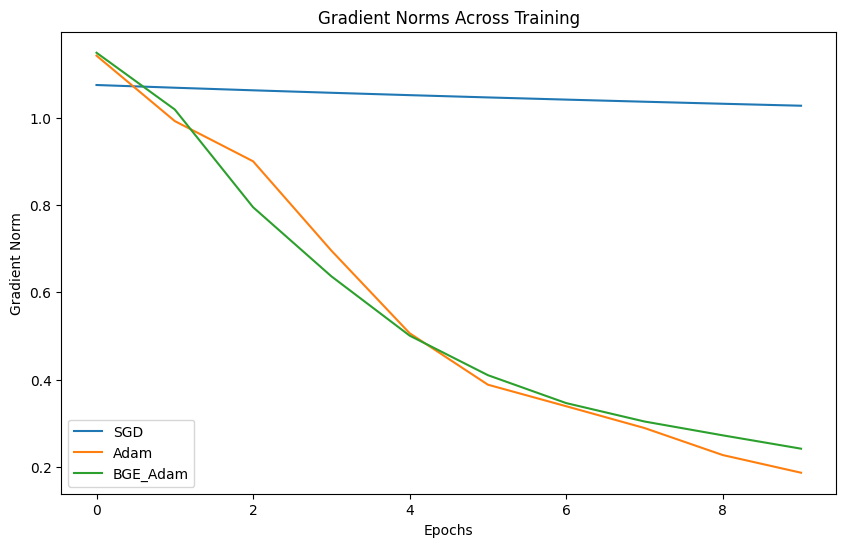

In [ ]:
# Affichage des normes de gradients pour chaque optimiseur
plt.figure(figsize=(10, 6))
for name, opt_class in optimizers.items():
    grad_norms = track_gradient_norms(LogisticRegression, opt_class, X_train_tensor, y_train_tensor, input_dim, num_classes, lr=0.01)
    plt.plot(grad_norms, label=name)

plt.title('Gradient Norms Across Training')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()


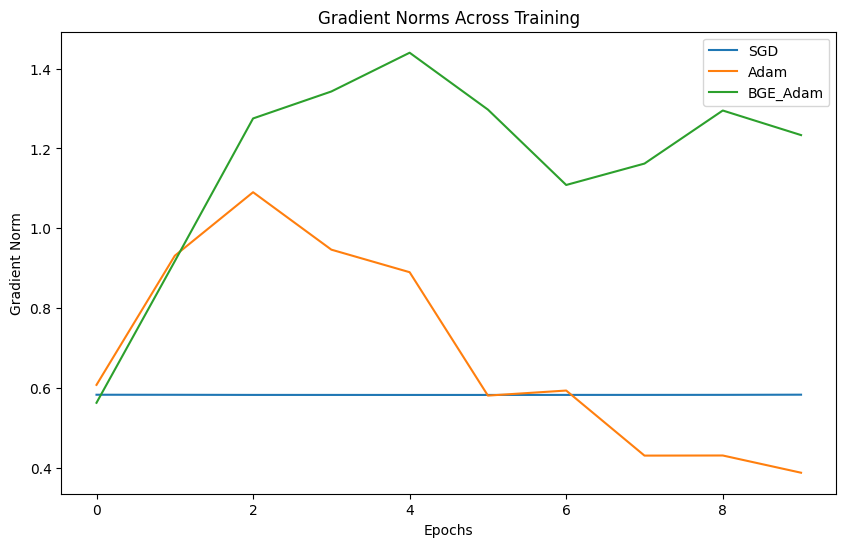

In [75]:
# Affichage des normes de gradients pour chaque optimiseur
plt.figure(figsize=(10, 6))
for name, opt_class in optimizers.items():
    grad_norms = track_gradient_norms(SimpleNN, opt_class, X_train_tensor, y_train_tensor, lr=0.01)
    plt.plot(grad_norms, label=name)

plt.title('Gradient Norms Across Training')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

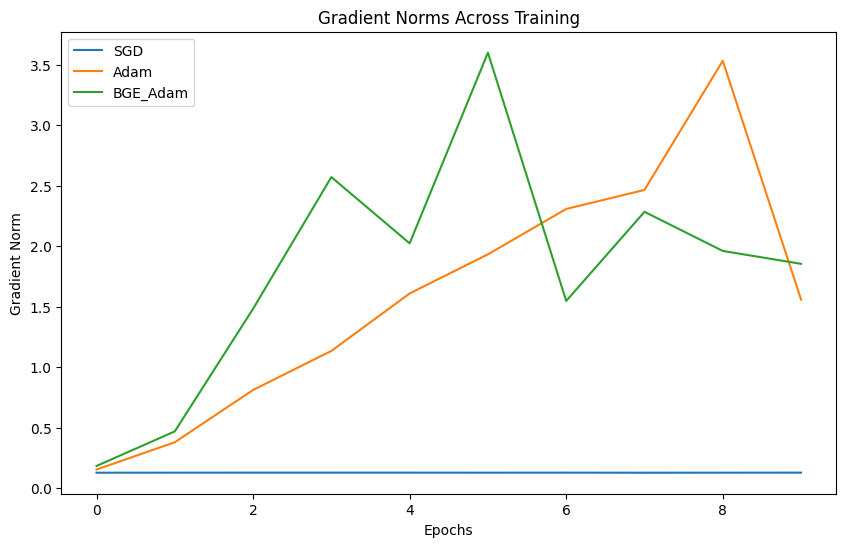

In [76]:
# Affichage des normes de gradients pour chaque optimiseur
plt.figure(figsize=(10, 6))
for name, opt_class in optimizers.items():
    grad_norms = track_gradient_norms(ComplexNN, opt_class, X_train_tensor, y_train_tensor, lr=0.01)
    plt.plot(grad_norms, label=name)

plt.title('Gradient Norms Across Training')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()